In [2]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [132]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,31978,None,None,88345.730970
2020-06-13,31979,None,None,81613.186307
2020-06-14,31980,None,None,75392.583846
2020-06-15,31981,None,None,69704.573726
2020-06-16,31982,None,None,64719.457907
...,...,...,...,...
2021-02-14,32225,None,None,248224.810817
2021-02-15,32226,None,None,240434.380224
2021-02-16,32227,None,None,233978.997210


In [133]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-02-18_2021-02-18-16-56.pickle


In [134]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-02-17_2021-02-17-16-16.pickle


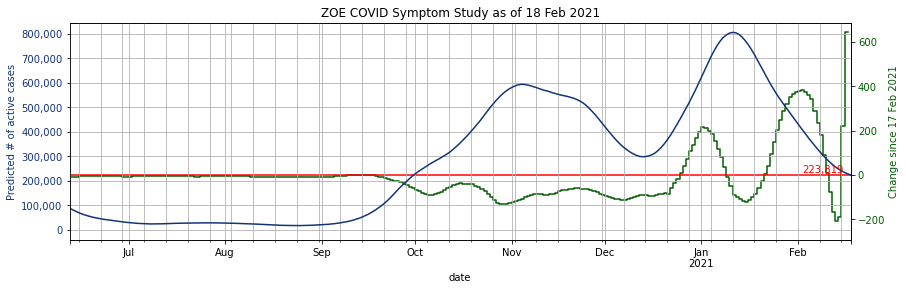

In [135]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

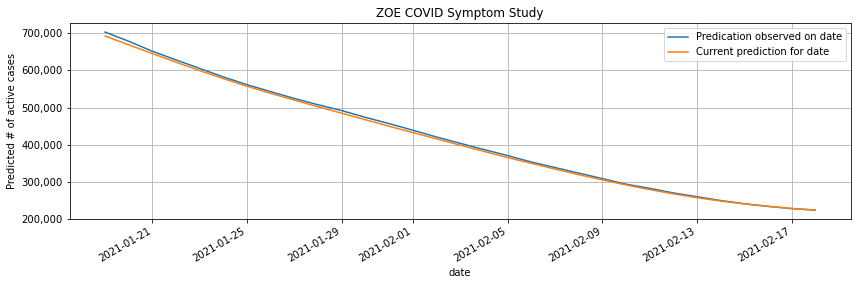

In [136]:
plot_study_evolution(curr_date, days=30)

In [137]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [138]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-02-18_2021-02-18-16-56.pickle


In [139]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
208,Forest Heath,E07000201,1.329913
280,Doncaster,E08000017,1.307756
317,Renfrewshire,S12000038,1.260373
270,Salford,E08000006,1.133935
343,Vale of Glamorgan,W06000014,1.096305
327,Gwynedd,W06000002,1.029070
82,Charnwood,E07000130,0.937395
260,Coventry,E08000026,0.921977
295,East Renfrewshire,S12000011,0.918056
347,Hammersmith and Fulham,E09000013,0.889404
